In [3]:
import pandas as pd
import cobra
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linprog
import scipy
import mip

def save_dict(data, name):
    with open(name, 'w' ) as file:
        json.dump( data, file )

# Community modeling

In this notebook we will implement a method to create community models of two or more species specific metabolic models using cobrapy.

In [4]:
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.282365392532252
Growth:  2.558694612613397


In [5]:
for rec in model_SA.reactions:
    rec.lower_bound = max(rec.lower_bound, -1000)
    rec.upper_bound = min(rec.upper_bound, 1000)

In [6]:
snm3 = pd.read_csv("SNM3.csv", sep =";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


In [7]:
BIOMASS_DP = "Growth" 
BIOMASS_SA = "BIOMASS_iYS_wild_type"
models = [model_DP.copy(), model_SA.copy()]

In [8]:
import json
compm_SA = json.loads(open("compm_SA.json").read())
compm_DP = json.loads(open("compm_DP.json").read())
compm = dict(list(compm_SA.items()) + list(compm_DP.items()))

The following metabolites have been previously added to obtain growth on the medium: EX_ile__L_e, EX_met__L_e and EX_26dap__M_e for DP. In the community this may is not necessary as the metabolites could be produced from e.g. SA.

**PROBLEM:** SA does not have EX_26dap__M_e and hence cannot produce it for DP....

Thus we cannot drop EX_26dap__M_e from the medium otherwise DP could not grow...

In [9]:
print(model_SA.exchanges.EX_met__L_e)
print(model_SA.exchanges.EX_ile__L_e)
#print(model_SA.exchanges.EX_26dap__M_e)

EX_met__L_e: met__L_e --> 
EX_ile__L_e: ile__L_e --> 


In [10]:
# Can produces met
with model_SA as model: 
    model.objective = model.exchanges.EX_met__L_e
    print(model.slim_optimize())

10.0


In [11]:
# Can produces ile
with model_SA as model: 
    model.objective = model.exchanges.EX_ile__L_e
    print(model.slim_optimize())

21.406249999999982


In [15]:
model_SA.compartments

{'c': 'cytosol', 'w': 'wildtype staph aureus', 'e': 'extracellular space'}

In [18]:
# Maybe add this as exchange reaction...
model_SA.metabolites.get_by_id("26dap__M_c")

Metabolite identifier,26dap__M_c
Name,"Meso-2,6-Diaminoheptanedioate"
Memory address,0x01c2b8bb7c08
Formula,C7H14N2O4
Compartment,c
In 2 reaction(s),"DAPDC, DAPE"


## 1) Constructing of community model explicitely

Here we introduce only shuttle reactions for reactions that are common in the uptake/sekretion reactions of the individual models!

In [156]:
def create_stoichiometry_matrix(model):
    metabolites = model.metabolites 
    reactions = model.reactions 
    S = np.zeros((len(metabolites), len(reactions)))
    
    met_id = dict()
    rec_id = dict()
    for i,reaction in enumerate(model.reactions):
        rec_id[reaction.id] = i
        for metabolite, stoich in reaction.metabolites.items():
            met_id[metabolite.id] = int(metabolites.index(metabolite))
            S[metabolites.index(metabolite), i] = stoich
    return S, met_id, rec_id 

In [157]:
class Model():
    def __init__(self, model, biomass_function):
        """ This is a new class of metabolic model, capable of flux balance analysis
        Attributes:
        models (list): CobraPy models of single organisms which will be used in construction
        biomass_reactions (list): List of strings containing the ids for the growth reactions
        """
        self.biomass_function = biomass_function
        self.model = model
        self.id = model.id
        # Compute stoichimetry_matrix
        S, met_id, rec_id = create_stoichiometry_matrix(model)
        self.num_reactions = S.shape[1]
        self.num_metabolites = S.shape[0]
        self.stoichiometry_matrix = scipy.sparse.csr_matrix(S)
        self.met_id = met_id
        self.rec_id = rec_id 
        # Set objective
        idx = self.rec_id[biomass_function]
        c = np.zeros(self.num_reactions)
        c[idx] = 1
        self.objective_c = c
        # Set bounds
        self._reset_bounds()
    
    @property
    def reactions(self):
        return self.model.reactions
    @property
    def exchanges(self):
        return self.model.exchanges
    @property
    def metabolites(self):
        return self.model.metabolites
    @property
    def medium(self):
        return self.model.medium

    def set_medium(self, medium):
        ex_ids = [ex.id for ex in self.exchanges]
        new_med = {}
        for key,val in medium.items():
            if key in ex_ids:
                new_med[key] = val
        self.model.medium = new_med
        self._reset_bounds()
        
    def optimize(self, disp=False):
        sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
        sol["fun"] = -sol["fun"] # As we have to minimize
        return sol 
    
    def slim_optimize(self, disp=False):
        sol = self.optimize(disp=disp)
        return sol["fun"]

    def summary(self):
        sol = self.optimize()
        flux = sol["x"]
        ex_ids = [ex.id for ex in self.exchanges]
        fluxes = []
        for ex in ex_ids:
            idx = self.rec_id[ex]
            fluxes.append(flux[idx])
        summary_df = pd.DataFrame({"Exchange reaction": ex_ids, "Flux": fluxes})
        summary_df.sort_values(["Flux"], inplace=True)
        return summary_df

    def _reset_bounds(self):
        self.bounds = []
        for rec in self.model.reactions:
            self.bounds.append((rec.lower_bound, rec.upper_bound))

    def __add__(self, model2):
        """ Adding another model creates a community model """
        return CommunityModel([self,model2], [1.,1.])
    

In [158]:
model_DP.medium = compm_DP 
model_SA.medium = compm_SA

In [159]:
model1 = Model(model_DP, BIOMASS_DP)
model2 = Model(model_SA, BIOMASS_SA)

$$ \max \sum_{i=1}^n \theta_i \text{ subject to }$$

$$ SV = 0, V_{j,min} \leq V_j \leq V_{j, max}, V_{Growth} \geq MBR/10 , V_{i, COOPM} + V_{i, min}\theta_i \geq V_{i,\min} $$

In [160]:
from mip import Model, xsum, maximize, BINARY

model1.set_medium(compm)
model2.set_medium(compm)

S1 = model1.stoichiometry_matrix.todense()
S1_dict = model1.rec_id 
bounds1 = model1.bounds 
obj1 = np.where(model1.objective_c > 0)[0][0]

S2 = model2.stoichiometry_matrix.todense()
S2_dict = model2.rec_id 
bounds2 = model2.bounds
obj2 = np.where(model2.objective_c > 0)[0][0]

We will add following constraints:
* All EX_ile__L_e used by DP must be produced by SA.
* All EX_met__L_E used by DP must be produced by SA.

In [161]:
from mip import Model, xsum, maximize, BINARY

comm_model = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in compm.items():
    x = comm_model.add_var(lb=-val, ub=1000)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [comm_model.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [comm_model.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    comm_model.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    comm_model.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)
# Shuttel constraints

for i,key in enumerate(compm):
    if "EX_ile__L_e" == key:
        idx1 = id1[i]
        idx2 = id2[i]
        # Sa must produce it...
        comm_model.add_constr(x1[idx1] + x2[idx2] == 0)
    elif "EX_met__L_e" == key:
        idx1 = id1[i]
        idx2 = id2[i]
        # Sa must produce it
        comm_model.add_constr(x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        comm_model.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        comm_model.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        comm_model.add_constr(-x_sh[i] + x2[idx] == 0)



In [162]:
def get_exchange_flux(S_dict, x):
    dic ={}
    for key, val in S_dict.items():
        if "EX_" in key:
            dic[key] = x[val].x
    return dic

def get_medium(x):
    dic = {}
    for key, val in x.items():
        dic[key] = val.lb
    return dic

First looking at the convex combinaiton

In [163]:
alphas = np.linspace(0,1,1000)
DP_growth = []
SA_growth = []
for a in alphas:
    comm_model.objective = maximize(a*x1[obj1] + (1-a)*x2[obj2])
    comm_model.optimize()
    DP_growth.append(x1[obj1].x)
    SA_growth.append(x2[obj2].x)

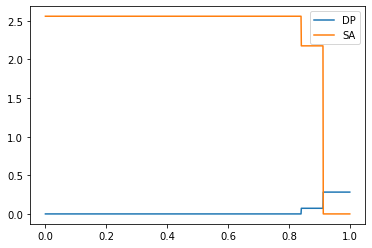

In [108]:
plt.plot(alphas, DP_growth)
plt.plot(alphas, SA_growth)
plt.legend(["DP", "SA"])

In [109]:
# SA dominates
w1 = 0.85
w2 = 0.15

comm_model.objective = maximize(w1*x1[obj1] + w2*x2[obj2])
comm_model.optimize()
print(x1[obj1].x)
print(x2[obj2].x)
minMBR = (w1*x1[obj1].x + w2*x2[obj2].x)/10
print(minMBR)

0.07015813422493124
2.203999676684123
0.039023436559380995


In [113]:
comm_model.objective = maximize(x1[obj1])
comm_model.optimize()
x1[obj1].x

0.2823653925310129

In [117]:
print("DP flux:", x1[S1_dict["EX_ile__L_e"]].x)
print("SA flux:", x2[S2_dict["EX_ile__L_e"]].x)
print("DP flux:", x1[S1_dict["EX_met__L_e"]].x)
print("SA flux:", x2[S2_dict["EX_met__L_e"]].x)

DP flux: -0.07944457699566038
SA flux: 0.07944457699566038
DP flux: -0.042086109860761715
SA flux: 0.042086109860761715


In [118]:
interchange = {"DP_flux":[], "SA_flux":[]}
index = list()
for key, val in get_exchange_flux(S1_dict,x1).items():
    other_echange = get_exchange_flux(S2_dict,x2)
    if val < 0 and abs(val) > 1e-4:
        print(key, val)
        index += [key]
        if key in other_echange:
            print("Other exchange",key, other_echange[key])

EX_glc__D_e -10.0
Other exchange EX_glc__D_e 0.0
EX_h2o_e -2.012868900097072
Other exchange EX_h2o_e 37.269586258971295
EX_leu__L_e -0.12319680565580232
Other exchange EX_leu__L_e 3.299353852199314e-13
EX_4abz_e -0.00018293671911059656
EX_ala__L_e -0.6181950007073012
EX_cl_e -0.016592706807311383
Other exchange EX_cl_e 5.203131743423912e-15
EX_pi_e -0.2413552445837733
Other exchange EX_pi_e -1.3146507812335253
EX_ribflv_e -0.00012195781271985231
Other exchange EX_ribflv_e 3.1364384285662163e-16
EX_gly_e -0.2819337819558233
EX_thr__L_e -0.06937020553157557
EX_arg__L_e -6.423710888358988
Other exchange EX_arg__L_e 10.00000000000067
EX_lys__L_e -0.09383669275954536
Other exchange EX_lys__L_e -0.34258786268974944
EX_k_e -0.01504569851987454
Other exchange EX_k_e 1.9510693324644316e-13
EX_pro__L_e -0.06044704997934305
EX_ca2_e -0.014677908938560053
EX_mg2_e -0.024203301149541657
Other exchange EX_mg2_e 8.671536001308067e-15
EX_mn2_e -0.010707719788877277
Other exchange EX_mn2_e 6.9136928254

In [27]:
# Check for medium
medium = get_medium(x_sh_dict)
for key in medium:
    assert key in compm

In [139]:
for key, val in get_exchange_flux(S2_dict, x2).items():
    if val < 0:
        assert key in medium
for key, val in get_exchange_flux(S1_dict, x1).items():
    if val < 0:
        if not key in medium:
            print(key, val)

In [169]:
m = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in compm.items():
    V_min = -10
    if key == "EX_o2_e":
        V_min = -20
    if "_fe" in key:
        V_min = -0.1
    x = m.add_var(lb=V_min, ub=100)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [m.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [m.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    m.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    m.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)

for i,key in enumerate(compm):
    if "EX_ile__L_e" == key:
        idx1 = id1[i]
        idx2 = id2[i]
        # Sa must produce it...
        m.add_constr(x1[idx1] + x2[idx2] == 0)
    elif "EX_met__L_e" == key:
        idx1 = id1[i]
        idx2 = id2[i]
        # Sa must produce it
        m.add_constr(x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        m.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        m.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        m.add_constr(-x_sh[i] + x2[idx] == 0)


# thetas
thetas = []
thetas_constraint = []
for x in x_sh:
    V_min = -10
    if key == "EX_o2_e":
        V_min = -20
    if "_fe" in key:
        V_min = -0.1
    theta = m.add_var(var_type=BINARY)
    thetas_constraint += [m.add_constr(x + V_min*theta >= V_min)]
    thetas.append(theta)
# Both must grow
growth_const1 = m.add_constr(x1[obj1] >= minMBR)
growth_const2 = m.add_constr(x2[obj2] >= minMBR)

In [170]:
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [171]:
m.objective = maximize(xsum(thetas))
m.optimize()
print(x1[obj1].x)
print(x2[obj2].x)

0.039023436559380995
0.039023436559380995


In [172]:
flux = [x.x for x in x_sh]
coopm = dict()
for f, key in zip(flux, compm.keys()):
    if f < 0:
        coopm[key] = abs(f)
save_dict(coopm, "COOPM_COM")
coopm

{'EX_zn2_e': 0.0012555738655083662,
 'EX_na1_e': 0.08117343149278419,
 'EX_thm_e': 2.5831854032775316e-05,
 'EX_o2_e': 1.0097001913410766,
 'EX_cys__L_e': 0.20108733794331468,
 'EX_glc__D_e': 2.4932587916729148,
 'EX_nac_e': 0.000468036820717438,
 'EX_so4_e': 0.001007321606562535,
 'EX_k_e': 0.009325606207106346,
 'EX_fe2_e': 0.0034874962433071193,
 'EX_mg2_e': 0.0036670028685560066,
 'EX_mobd_e': 2.7316405591566695e-07,
 'EX_mn2_e': 0.0015055047475846246,
 'EX_cl_e': 0.0024863878303120037,
 'EX_26dap__M_e': 0.0037791037342113872,
 'EX_cu2_e': 0.0012793696875551123,
 'EX_ni2_e': 0.001385144260945475,
 'EX_ca2_e': 0.0020285150497873403,
 'EX_cobalt2_e': 0.001379508089928548,
 'EX_thr__L_e': 0.04855088204493428,
 'EX_4abz_e': 2.5282203672460678e-05,
 'EX_pro__L_e': 0.008353897759660993}

As we can see the exchanges that or not in the medium are produced by the other organism!!!

In [173]:
coopm_DP = coopm.copy()
interchange = {"DP_flux":[], "SA_flux":[]}
index = list()
for key, val in get_exchange_flux(S1_dict,x1).items():
    other_echange = get_exchange_flux(S2_dict,x2)
    if val < 0 and abs(val) > 1e-7 and key not in coopm:
        print(key, val)
        index += [key]
        interchange["DP_flux"] += [val]
        if key in other_echange:
            print("Other exchange",key, other_echange[key])
            interchange["SA_flux"] += [other_echange[key]]
        else:
            interchange["SA_flux"] += "na"
        coopm_DP[key] = abs(val)

EX_leu__L_e -0.01702603384477992
Other exchange EX_leu__L_e 0.017026033844779916
EX_pi_e -0.03335575578495254
Other exchange EX_pi_e 0.03335575578495254
EX_ribflv_e -1.6854802654582774e-05
Other exchange EX_ribflv_e 1.6854802654582774e-05
EX_arg__L_e -0.011178286517498545
Other exchange EX_arg__L_e 0.011178286517498545
EX_lys__L_e -0.012968410165357134
Other exchange EX_lys__L_e 0.01296841016535713
EX_glu__L_e -0.02369456471178522
Other exchange EX_glu__L_e 0.02369456471178522
EX_his__L_e -0.0035802472957171855
Other exchange EX_his__L_e 0.0035802472957171855
EX_ile__L_e -0.010979392287970777
Other exchange EX_ile__L_e 0.010979392287970777
EX_met__L_e -0.005816380766287394
Other exchange EX_met__L_e 0.005816380766287394
EX_trp__L_e -0.002148155935637779
Other exchange EX_trp__L_e 0.002148155935637779
EX_val__L_e -0.016199137126513535
Other exchange EX_val__L_e 0.01619913712651353
EX_phe__L_e -0.012212589418514873
Other exchange EX_phe__L_e 0.012212589418514875


In [174]:
coopm_SA = coopm.copy()
for key, val in get_exchange_flux(S2_dict,x2).items():
    other_echange = get_exchange_flux(S1_dict,x1)
    if val < 0 and key not in coopm and abs(val) > 1e-4:
        print(key, val)
        interchange["SA_flux"] += [val]
        interchange["DP_flux"] += [other_echange[key]]
        if key in other_echange:
            print("Other exchange",key, other_echange[key])
        coopm_SA[key] = abs(val)

In [175]:
df = pd.DataFrame(interchange, index = index)
df.to_csv("interchange.csv")

This means that SA is producing stuff that DP needs ! Where SA can grow on this medium alone!

In [176]:
coopm_SA = dict([(key,val) for key,val in coopm_SA.items() if key in model_SA.exchanges])
model_SA.medium = coopm_SA
model_SA.slim_optimize()

0.04080092057943412

In [177]:
coopm_DP = dict([(key,val) for key,val in coopm_DP.items() if key in model_DP.exchanges])
model_DP.medium = coopm_DP
model_DP.slim_optimize()

0.03902343656043972

In [178]:
m = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in coopm.items():
    x = m.add_var(lb=-val, ub=1000)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [m.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [m.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    m.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    m.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)
# Shuttel constraints
for i in range(len(coopm)):
    if id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        m.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        m.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        m.add_constr(-x_sh[i] + x2[idx] == 0)


In [179]:
m.objective = maximize(x1[obj1] + x2[obj2])
m.optimize()
print(x1[obj1].x)
print(x2[obj2].x)

0.039023436559433494
0.039023436558758104


In [180]:
m.objective = maximize(x1[obj1])
m.optimize()
print(x1[obj1].x)

0.03902343655938098


In [181]:
m.objective = maximize(x2[obj2])
m.optimize()
print(x2[obj2].x)

0.04080092057627138


## Sensitivity analysis

In [182]:
SA_growths = {}
DP_growths = {}
for i,key in enumerate(coopm): 
    vals = np.linspace(-10,0, 100)
    for val in vals:
        x_sh[i].lb = val
        m.objective = maximize(w1*x1[obj1] + w2*x2[obj2])
        m.optimize()
        if key in SA_growths and key in DP_growths:
            DP_growths[key].append(x1[obj1].x)
            SA_growths[key].append(x2[obj2].x)
        else:
            DP_growths[key] = [x1[obj1].x]
            SA_growths[key] = [x2[obj2].x]
    x_sh[i].lb = -coopm[key]

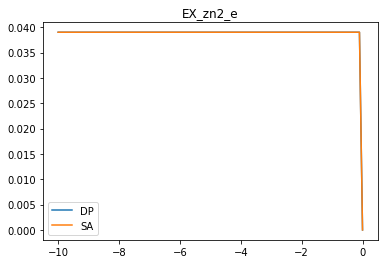

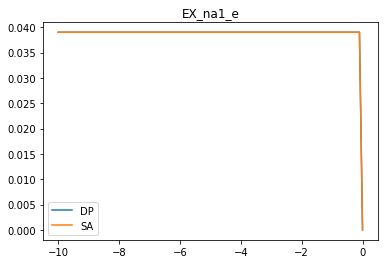

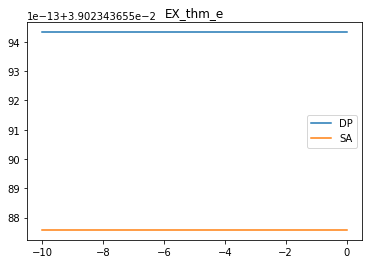

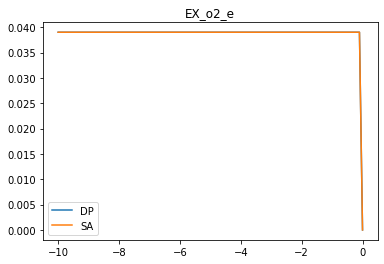

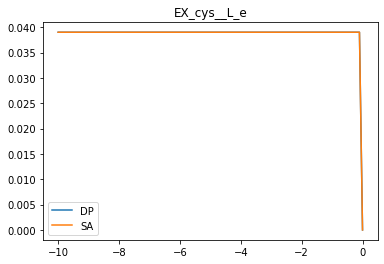

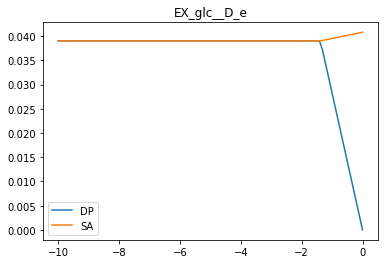

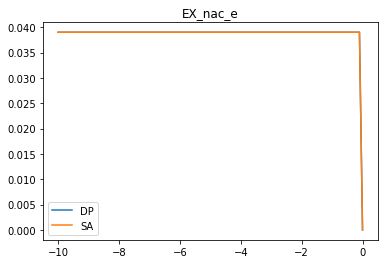

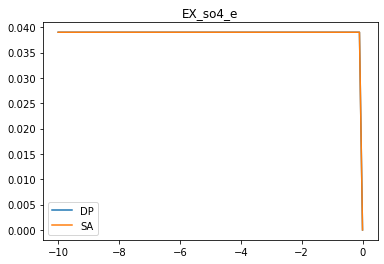

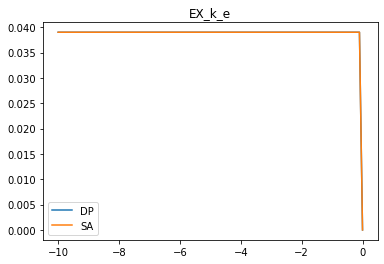

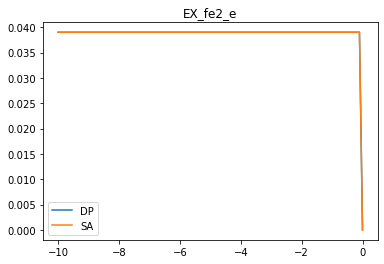

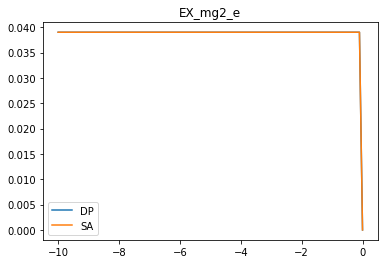

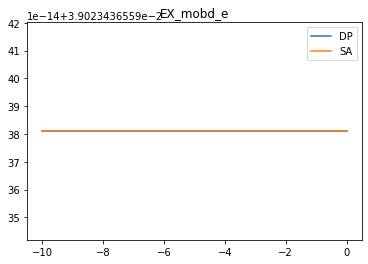

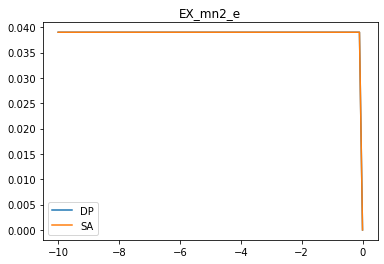

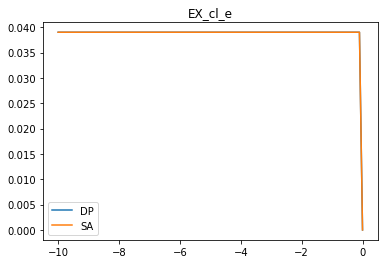

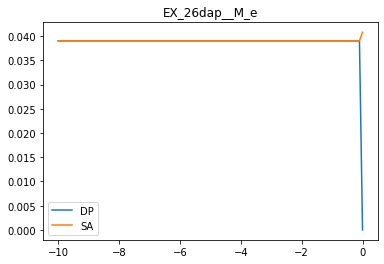

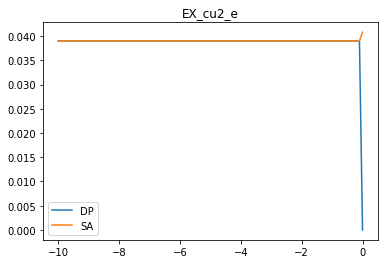

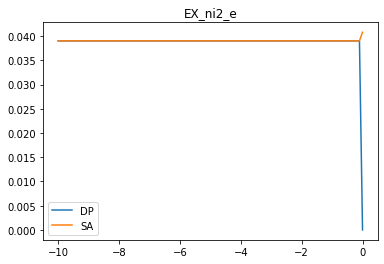

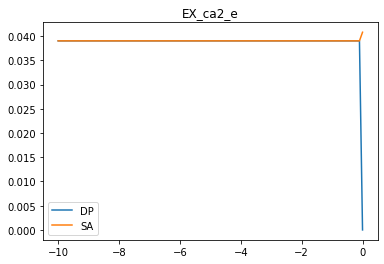

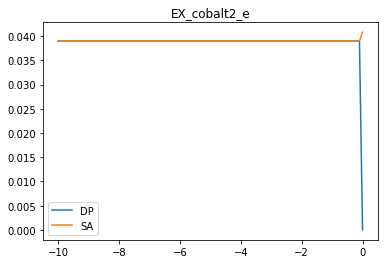

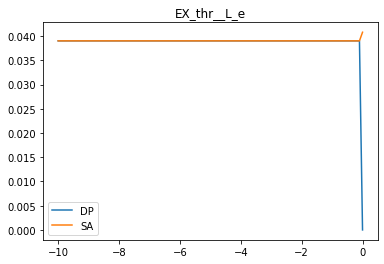

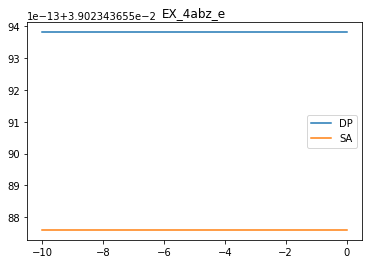

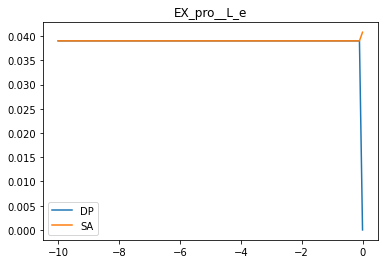

In [183]:
for key in coopm:
    plt.title(key)
    plt.plot(vals, DP_growths[key])
    plt.plot(vals, SA_growths[key])
    plt.legend(["DP", "SA"])
    plt.show()